In [1]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from stereoid.oceans.scene_preparation.scene_tools import read_scene
from stereoid.oceans.scene_preparation.read_scenarios import read_scenario_ifremer
from drama.geo.derived_geo import BistaticRadarGeometry
from stereoid.instrument import ObsGeo
from stereoid.oceans.visualization.geo_plot import geoplot

## Define observation geometry

In [2]:
# Incident angle
par_file = Path(
    "/home/andreas/Code/stereoid_public/stereoid_inputs_and_outputs/PAR/Harmony_ocean_IWS.cfg"
)
incm = 31
along_track_separation = 350e3
companion_delay = along_track_separation / 7.4e3
cmpgeo_a = BistaticRadarGeometry(par_file=par_file, companion_delay=-companion_delay)

obsgeo_a = ObsGeo.from_companion_polarizations(
    np.radians(incm), cmpgeo_a, ascending=True
)

In [3]:
nrcs_path = Path(
    "/home/andreas/Code/stereoid_public/stereoid_inputs_and_outputs/RESULTS/OceanE2E/Scenarios/Ifremer 2024-06-06/nrcs_L1_All_obs_nonoise_Ifremer_350_05.nc"
)
doppler_path = Path(
    "/home/andreas/Code/stereoid_public/stereoid_inputs_and_outputs/RESULTS/OceanE2E/Scenarios/Ifremer 2024-06-06/dop_L1_All_obs_nonoise_Ifremer_350_05.nc"
)
model_path = Path(
    "/home/andreas/Code/stereoid_public/stereoid_inputs_and_outputs/RESULTS/OceanE2E/Scenarios/Ifremer 2024-06-06/All_obs_Ifremer_350_05_model.nc"
)
nrcs_ds = xr.open_dataset(nrcs_path)
dop_ds = xr.open_dataset(doppler_path)

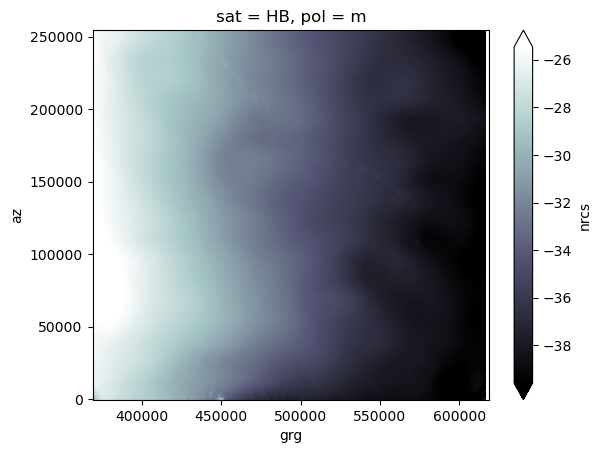

In [4]:
(10 * np.log10(nrcs_ds.nrcs.sel(pol="m", sat="HB"))).plot(robust=True, cmap="bone")

In [5]:
mars_path = Path(
    "/home/andreas/Code/WSOA Scientific Workbench/Plotting/Ifremer/MARC_L1-MARS2D-MANGA700_20240101T0000Z_MeteoMF.nc"
)
mars_3d_path = Path(
    "/home/andreas/Code/WSOA Scientific Workbench/Plotting/Ifremer/MARC_F1-MARS3D-MANGAE2500_20240101T0000Z.nc"
)
ww3_path = Path(
    "/home/andreas/Code/WSOA Scientific Workbench/Plotting/Ifremer/MARC_WW3-NORGAS-UG_20240101T00Z.nc"
)
ww3_spectra_path = Path(
    "/home/andreas/Code/WSOA Scientific Workbench/Plotting/Ifremer/MARC_WW3-62024_20240101T00Z.nc"
)

In [6]:
model_dic, _ = read_scene(
    (mars_path, mars_3d_path, ww3_path),
    ([40e3, 295e3], [95e3, 365e3]),
    read_scenario_ifremer,
    0,
    1000,
)

In [7]:
model_ds = xr.open_dataset(model_path)
grid_spacing = 1000

In [8]:
obsgeo_a.set_swath(
    np.deg2rad(incm),
    np.arange(model_ds.tsc_v.shape[1]).reshape((1, model_ds.tsc_v.shape[1]))
    * grid_spacing,
)

In [9]:
xr_l1 = xr.Dataset(
    {
        "NRCS": (("az", "gr", "sat"), nrcs_ds.nrcs.sel(pol="M").to_numpy()),
        "GDC": (
            ("az", "gr", "sat"),
            dop_ds.dop.sel(pol="M").to_numpy(),
            {"units": "Hz"},
        ),
        "latitude": (("az", "gr"), model_ds.latitude.to_numpy()),
        "longitude": (("az", "gr"), model_ds.longitude.to_numpy()),
        "incm": (("gr",), obsgeo_a.inc_m.flatten(), {"units": "deg"}),
    },
    coords={
        "gr": obsgeo_a.gr[0],
        "az": model_ds.az.to_numpy() * grid_spacing,
        "sat": ["S1", "HA", "HB"],
    },
)

In [10]:
xr_l1.to_netcdf(
    Path("/home/andreas/Code/WSOA Scientific Workbench/Results/l1_ifremer_scene.nc")
)

In [11]:
model_ds

<xarray.Dataset>
Dimensions:    (az: 255, grg: 250)
Dimensions without coordinates: az, grg
Data variables:
    ssha       (az, grg) float32 ...
    hs         (az, grg) float32 ...
    longitude  (az, grg) float32 -4.615 -4.603 -4.59 ... -1.567 -1.555 -1.542
    latitude   (az, grg) float32 43.64 43.64 43.64 43.64 ... 45.92 45.92 45.92
    sst        (az, grg) float32 ...
    tsc_v      (az, grg) float32 ...
    tsc_u      (az, grg) float32 ...
    wnd_u      (az, grg) float32 ...
    wnd_v      (az, grg) float32 ...
Attributes: (12/16)
    created_time:            2024-06-05T22:51:44Z
    description:             L2 for Harmony mission build using stereoid tools
    incident_angle:          31
    rx_ipc_name:             tud_2020_tripple_ati
    rx_cpc_name:             tud_2020_tripple
    mode:                    IWS
    ...                      ...
    lambda_min:              0.005
    lambda_max:              500
    n_k:                     128
    fetch:                   100000.0
    SAR_spectra_lambda_max:  2000
    SAR_spectra_looks:       25

In [12]:
# xr_model = xr.Dataset(
#     {
#         "U10s": (
#             ("az", "gr"),
#             np.sqrt(model_ds.wnd_u**2 + model_ds.wnd_v**2).to_numpy(),
#         ),
#         "SST": (("az", "gr"), model_ds.sst.to_numpy()),
#         "latitude": (("az", "gr"), model_ds.latitude.to_numpy()),
#         "longitude": (("az", "gr"), model_ds.longitude.to_numpy()),
#     }
# )

In [13]:
# xr_model.to_netcdf(Path("/home/andreas/Code/WSOA Scientific Workbench/Results/ifremer_model.nc"))

In [14]:
# geoplot(
#     xr_model,
#     "SST",
#     sat="HA",
#     cmap="inferno",
#     # vmin=8,
#     # vmax=15,
#     cblabelcolor="black",
# )

In [15]:
# geoplot(
#     xr_l1,
#     "NRCS",
#     sat="HA",
#     # vmin=-20,
#     # vmax=-8,
#     cmap="viridis",
#     basedata=None,
#     bcmap="inferno",
#     bvarname="SST",
#     alpha=0.5,
#     # bmin=8,
#     # bmax=15,
#     cblabelcolor="black",
# )

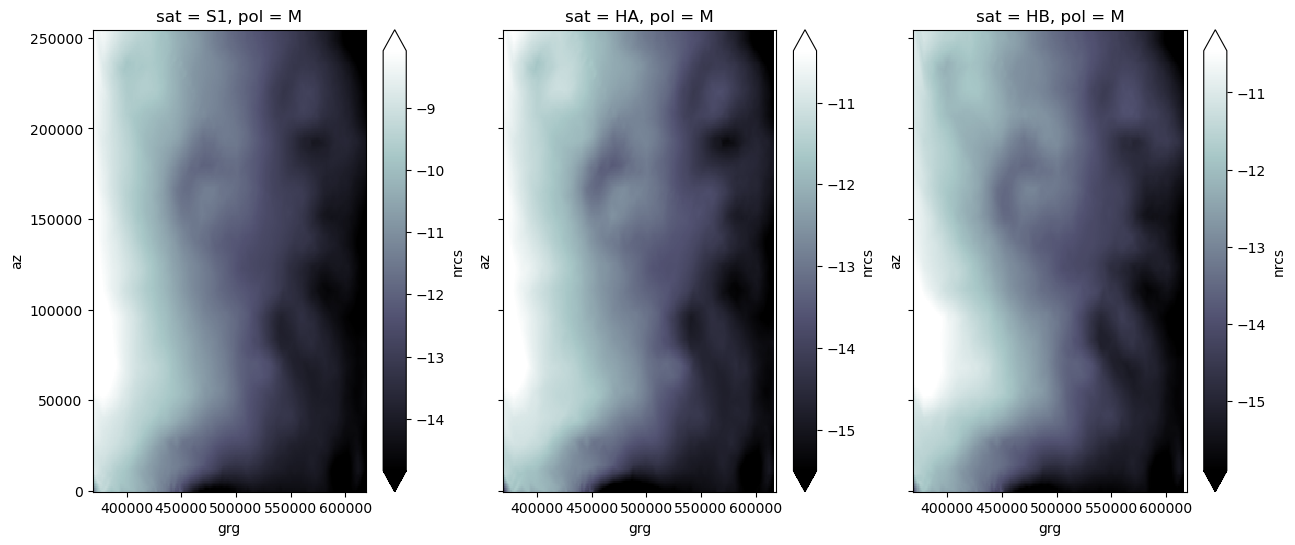

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
nrcs = 10 * np.log10(nrcs_ds.nrcs)
nrcs.sel(sat="S1", pol="M").plot(ax=axs[0], cmap="bone", robust=True)
nrcs.sel(sat="HA", pol="M").plot(ax=axs[1], cmap="bone", robust=True)
nrcs.sel(sat="HB", pol="M").plot(ax=axs[2], cmap="bone", robust=True)

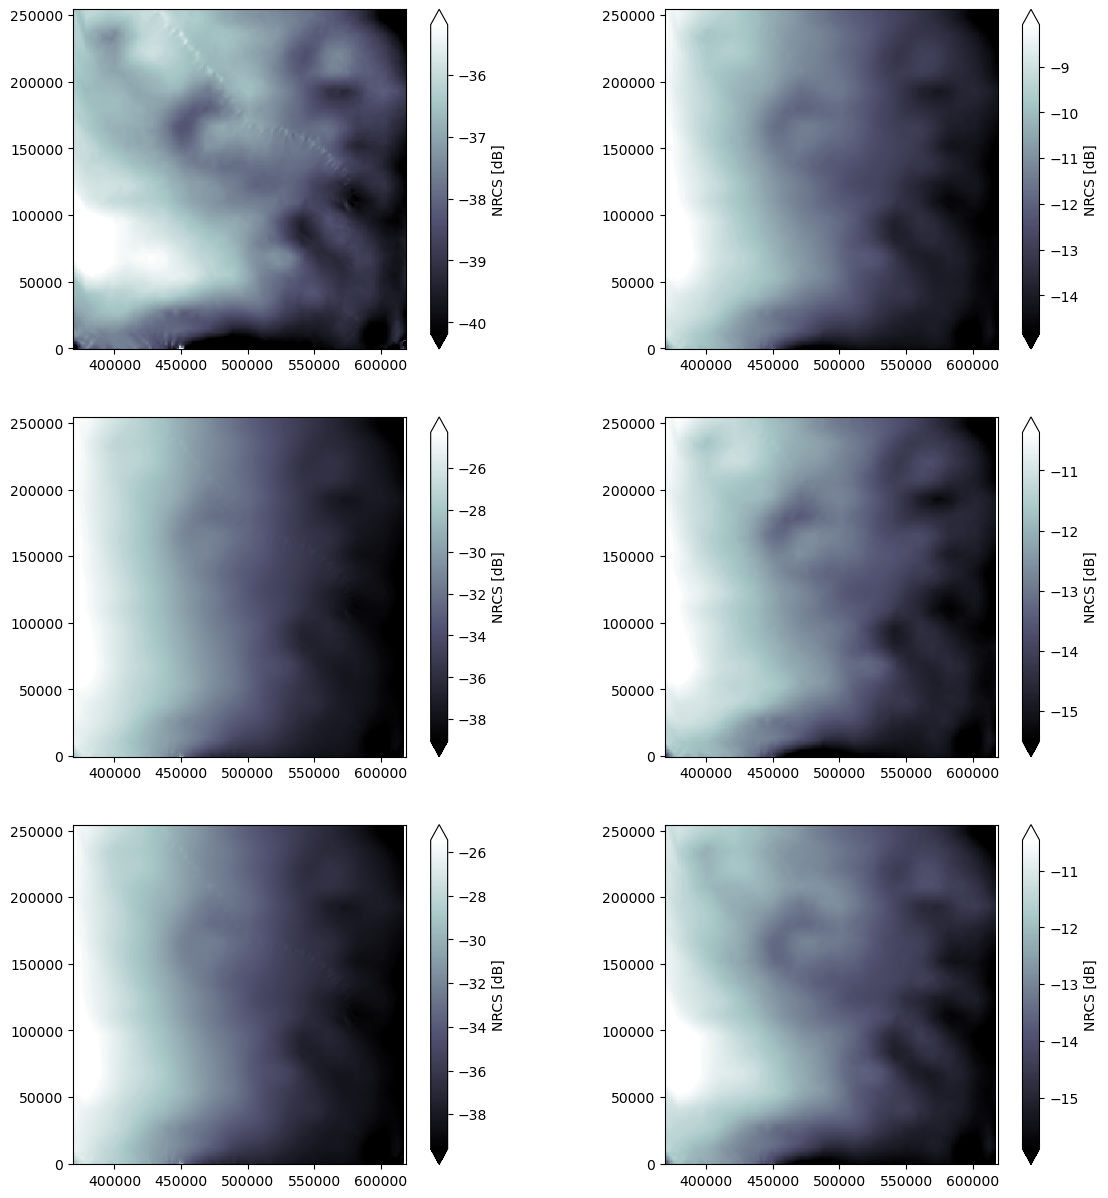

In [27]:
fig, axs = plt.subplots(3, 2, figsize=(14, 15))
for ax, (sat, pol) in zip(axs.flatten(), itertools.product(nrcs.sat, nrcs.pol)):
    nrcs.sel(sat=sat, pol=pol).plot.imshow(
        cmap="bone", origin="lower", interpolation="none", robust=True, ax=ax, add_labels=False, cbar_kwargs={"label": "NRCS [dB]"}
    )
    ax.set_aspect("equal")

In [28]:
fig.savefig(Path("/home/andreas/nrcs.png"), dpi=300, bbox_inches="tight")

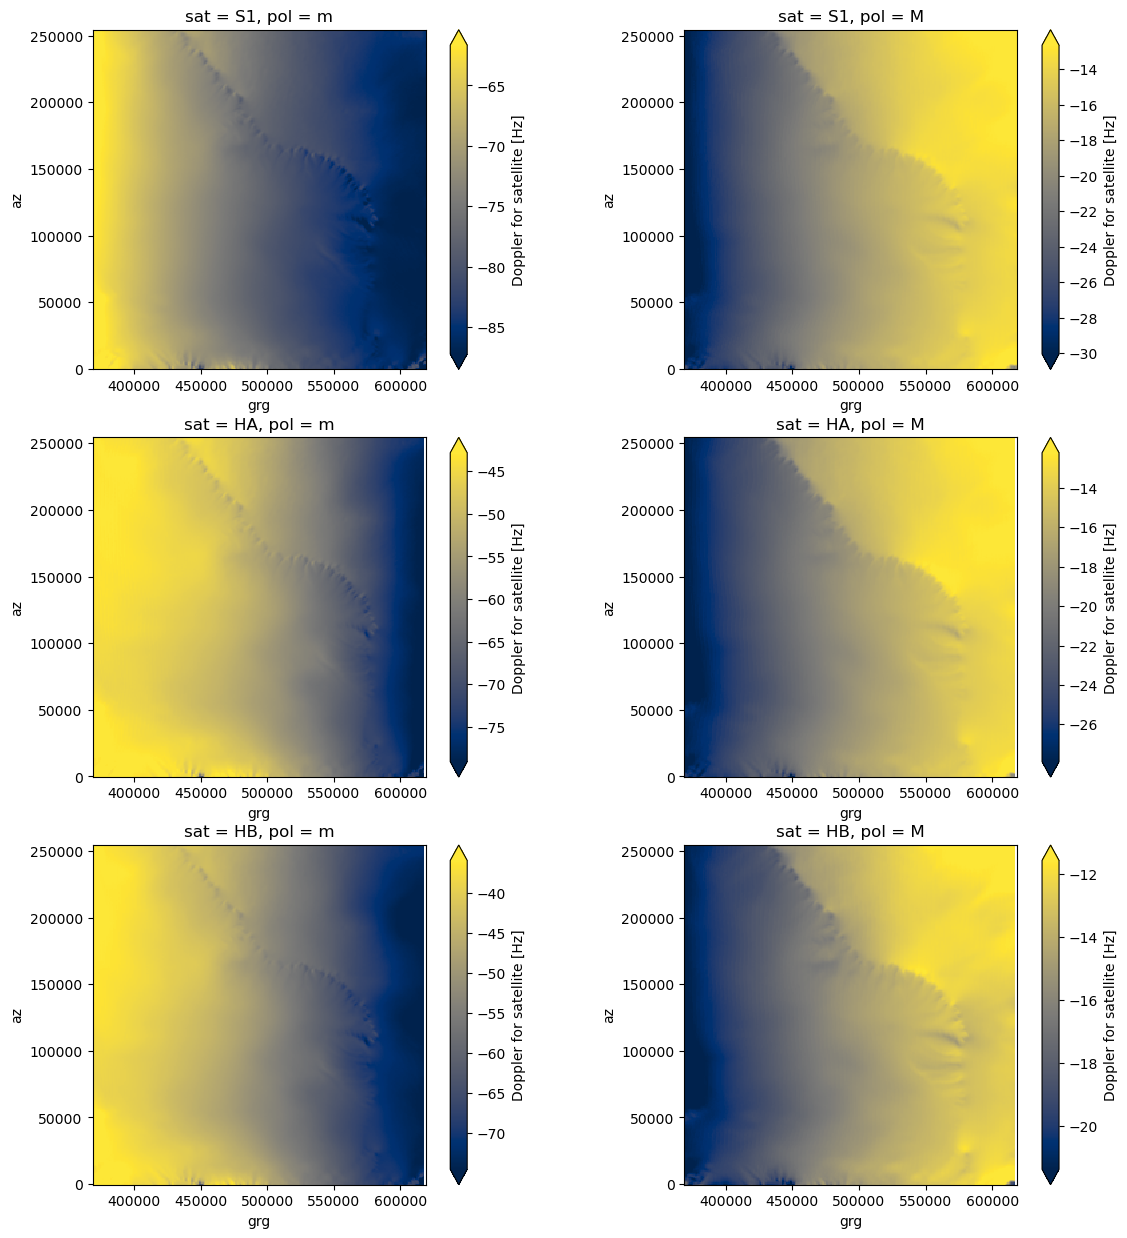

In [29]:
dop = dop_ds.dop
fig, axs = plt.subplots(3, 2, figsize=(14, 15))
for ax, (sat, pol) in zip(axs.flatten(), itertools.product(dop.sat, dop.pol)):
    dop.sel(sat=sat, pol=pol).plot.imshow(
        cmap="cividis", origin="lower", interpolation="none", robust=True, ax=ax
    )
    ax.set_aspect("equal")

In [30]:
fig.savefig(Path("/home/andreas/doppler.png"), dpi=300, bbox_inches="tight")